In [1]:
import numpy as np
from sklearn.decomposition import PCA  # Only for performing the primary Component Analysis
import matplotlib.pyplot as plt # For visualizations

import pydotplus
from graphviz import Source
from IPython.display import Image, display

from sklearn.tree import DecisionTreeClassifier #For reference decision_tree
from sklearn.metrics import classification_report

from sklearn.tree import export_graphviz
import graphviz

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Loading/preparing the data

In [2]:
train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

In [3]:
train_data.shape

(10000, 785)

In [4]:
test_data.shape

(5000, 785)

In [5]:
print(test_data)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 0 0 4]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 2]]


In [6]:
#Seperating the labels
train_labels = train_data[:, -1]
test_labels = test_data[:, -1]

In [7]:
#Dropping labels from data
train_data = train_data[:, :-1]
test_data = test_data[:, :-1]

In [8]:
# Check for NaN values in the dataset
print(f"NaN values in train_data: {np.isnan(train_data).sum()}")
print(f"NaN values in test_data: {np.isnan(test_data).sum()}")


NaN values in train_data: 0
NaN values in test_data: 0


In [9]:
epsilon = 1e-8  # Small constant to avoid division by zero

# Normalizing the data
train_data = (train_data - np.mean(train_data, axis=0)) / (np.std(train_data, axis=0) + epsilon)
test_data = (test_data - np.mean(test_data, axis=0)) / (np.std(test_data, axis=0) + epsilon)


In [10]:
print(test_data)

[[ 0.         -0.04142737 -0.03739899 ... -0.15091521 -0.06852437
  -0.02866199]
 [ 0.         -0.04142737 -0.03739899 ... -0.15091521 -0.06852437
  -0.02866199]
 [ 0.         -0.04142737 -0.03739899 ... -0.15091521 -0.06852437
  -0.02866199]
 ...
 [ 0.         -0.04142737 -0.03739899 ...  0.33911469 -0.06852437
  -0.02866199]
 [ 0.         -0.04142737 -0.03739899 ... -0.15091521 -0.06852437
  -0.02866199]
 [ 0.         -0.04142737 -0.03739899 ...  2.22923003 -0.06852437
  -0.02866199]]


In [11]:
# Define the number of components to keep
n_components = 4

# Make PCA model
pca = PCA(n_components=n_components)

# Fit PCA on the training data and transform both training and test data
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.fit_transform(test_data)

print(f"Original shape: {train_data.shape}")
print(f"Transformed shape: {train_data_pca.shape}")


Original shape: (10000, 784)
Transformed shape: (10000, 4)


Principle Component Analysis

In [13]:
# Define a function to plot PCA results with specified colors and labels for each category
def plot_pca(data, labels, title):
    plt.figure(figsize=(10, 7))
    colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'purple'}
    label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(data[indices, 0], data[indices, 1], color=colors[label], label=label_names[label], alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

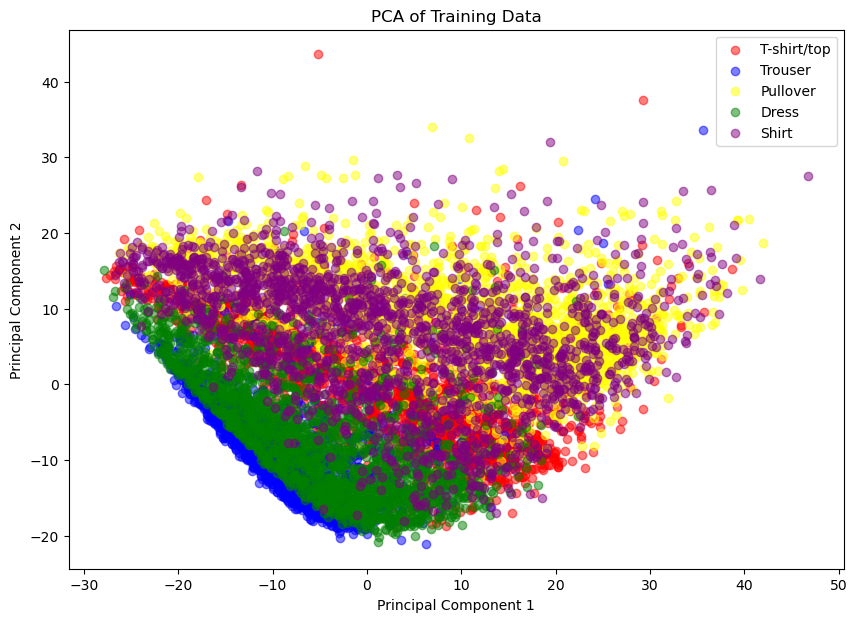

In [14]:
# Plotting the PCA results for the training data
plot_pca(train_data_pca, train_labels, 'PCA of Training Data')

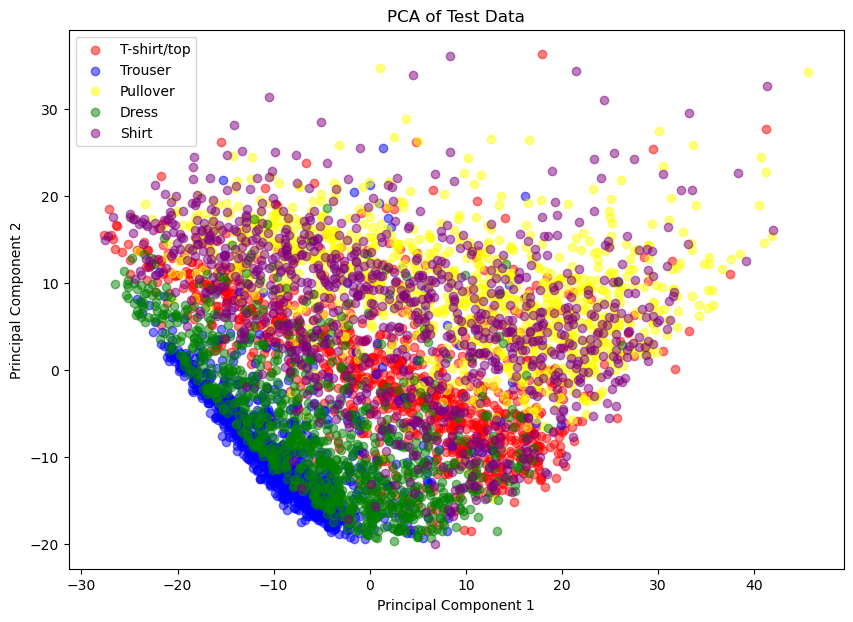

In [15]:
# Plotting the PCA results for the test data
plot_pca(test_data_pca, test_labels, 'PCA of Test Data')

In [16]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance by the first four principal components: {explained_variance_ratio}")
# Calculate the total variance explained by the first two principal components
total_explained_variance = np.sum(explained_variance_ratio)
print(f"Total variance explained by the first four principal components: {total_explained_variance * 100:.2f}%")


Explained variance by the first four principal components: [0.2220528  0.1409841  0.06415513 0.05433026]
Total variance explained by the first four principal components: 48.15%


In [17]:
def gini_impurity(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

In [18]:
def information_gain(left_labels, right_labels, current_impurity):
    p = len(left_labels) / (len(left_labels) + len(right_labels))
    return current_impurity - p * gini_impurity(left_labels) - (1 - p) * gini_impurity(right_labels)

In [19]:
def best_split(data, labels):
    best_gain = 0
    best_split = None
    current_impurity = gini_impurity(labels)
    n_features = data.shape[1]
    
    for feature in range(n_features):
        values = np.unique(data[:, feature])
        for val in values:
            left_indices = data[:, feature] <= val
            right_indices = data[:, feature] > val
            left_labels = labels[left_indices]
            right_labels = labels[right_indices]
            
            if len(left_labels) == 0 or len(right_labels) == 0:
                continue
            
            gain = information_gain(left_labels, right_labels, current_impurity)
            
            if gain > best_gain:
                best_gain = gain
                best_split = (feature, val)
    
    return best_split


In [20]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


In [21]:
def build_tree(data, labels, depth=0, max_depth=None):
    if len(np.unique(labels)) == 1:
        return DecisionTreeNode(value=labels[0])
    
    if max_depth is not None and depth >= max_depth:
        return DecisionTreeNode(value=np.bincount(labels).argmax())
    
    feature, threshold = best_split(data, labels)
    
    if feature is None:
        return DecisionTreeNode(value=np.bincount(labels).argmax())
    
    left_indices = data[:, feature] <= threshold
    right_indices = data[:, feature] > threshold
    
    left_node = build_tree(data[left_indices], labels[left_indices], depth + 1, max_depth)
    right_node = build_tree(data[right_indices], labels[right_indices], depth + 1, max_depth)
    
    return DecisionTreeNode(feature, threshold, left_node, right_node)


In [22]:
def predict(tree, data_point):
    if tree.value is not None:
        return tree.value
    
    if data_point[tree.feature] <= tree.threshold:
        return predict(tree.left, data_point)
    else:
        return predict(tree.right, data_point)


In [23]:
def predict_batch(tree, data):
    predictions = [predict(tree, data_point) for data_point in data]
    return np.array(predictions)


In [24]:
decision_tree = build_tree(train_data_pca, train_labels, max_depth=5)


In [25]:

predictions = predict_batch(decision_tree, train_data_pca)
print(f"Predictions: {predictions}")

Predictions: [0 4 0 ... 3 0 3]


In [26]:
# Make predictions on the test data
test_predictions = predict_batch(decision_tree, test_data_pca)


In [27]:
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']

In [28]:
# Calculate accuracy
accuracy_pca = np.mean(test_predictions == test_labels)
print(f"Accuracy with PCA: {accuracy_pca * 100:.2f}%")

Accuracy with PCA: 58.54%


In [29]:
# Generate the classification report with label names
report = classification_report(test_labels, test_predictions, target_names=label_names)
print(report)


              precision    recall  f1-score   support

 T-shirt/top       0.79      0.56      0.66      1000
     Trouser       0.97      0.41      0.58      1000
    Pullover       0.60      0.82      0.69      1000
       Dress       0.49      0.88      0.63      1000
       Shirt       0.36      0.25      0.30      1000

    accuracy                           0.59      5000
   macro avg       0.64      0.59      0.57      5000
weighted avg       0.64      0.59      0.57      5000



#This isn't working properly. It outputs a very squished tree.

import pydotplus
from graphviz import Source

def visualize_tree(tree, feature_names, output_file='homebrew_decision_tree.pdf'):
    label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    
    def recurse(node, depth=0):
        if node.value is not None:
            return f'leaf_{depth} [label="Class: {label_names[node.value]}", shape=box]'
        
        left = recurse(node.left, depth + 1)
        right = recurse(node.right, depth + 1)
        
        return f'node_{depth} [label="{feature_names[node.feature]} <= {node.threshold}"]\n' + \
               f'node_{depth} -> {left}\n' + \
               f'node_{depth} -> {right}\n' + \
               left + '\n' + right
    
    dot_string = 'digraph Tree {\n' + recurse(tree) + '\n}'
    graph = pydotplus.graph_from_dot_data(dot_string)
    graph.write_pdf(output_file)
    print(f"Decision tree saved as {output_file}")

# Assuming you have a trained decision tree and feature names
feature_names = [f'PC{i+1}' for i in range(train_data_pca.shape[1])]
visualize_tree(decision_tree, feature_names, output_file='homebrew_decision_tree.pdf')



In [30]:
#Reference Decision Tree using SciKitLearn
# Initialize the decision tree classifier with the same max_depth
clf = DecisionTreeClassifier(max_depth=5)

In [31]:
# Fit the model on the training data no need to renormalize or make a new PCA
clf.fit(train_data_pca, train_labels)

DecisionTreeClassifier(max_depth=5)

In [32]:
# Make predictions on the test data
test_predictions = clf.predict(test_data_pca)

In [33]:
# Calculate accuracy
accuracy_pca = np.mean(test_predictions == test_labels)
print(f"Accuracy with PCA: {accuracy_pca * 100:.2f}%")

Accuracy with PCA: 58.62%


In [34]:
# Generate the classification report with label names
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
report = classification_report(test_labels, test_predictions, target_names=label_names)
print(report)

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.56      0.66      1000
     Trouser       0.97      0.41      0.58      1000
    Pullover       0.60      0.82      0.69      1000
       Dress       0.49      0.88      0.63      1000
       Shirt       0.36      0.25      0.30      1000

    accuracy                           0.59      5000
   macro avg       0.64      0.59      0.57      5000
weighted avg       0.64      0.59      0.57      5000



# Export the decision tree to a DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=[f'PC{i+1}' for i in range(train_data_pca.shape[1])], 
                           class_names=label_names, 
                           filled=True, rounded=True, 
                           special_characters=True)

# Create a graph from the DOT data
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the visualization as a file
graph.view()  # Display the visualization


In [35]:
# Initialize LDA
lda = LinearDiscriminantAnalysis(n_components=2)

In [36]:
# Fit LDA on the training data and transform both training and test data
train_data_lda = lda.fit_transform(train_data, train_labels)
test_data_lda = lda.transform(test_data)

In [37]:
print(f"Original shape: {train_data.shape}")
print(f"Transformed shape: {train_data_lda.shape}")

Original shape: (10000, 784)
Transformed shape: (10000, 2)


In [38]:
# Define a function to plot LDA results with specified colors and labels for each category
def plot_lda(data, labels, title):
    plt.figure(figsize=(10, 7))
    colors = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green', 4: 'purple'}
    label_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Shirt'}
    
    for label in np.unique(labels):
        indices = labels == label
        plt.scatter(data[indices, 0], data[indices, 1], color=colors[label], label=label_names[label], alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')
    plt.show()

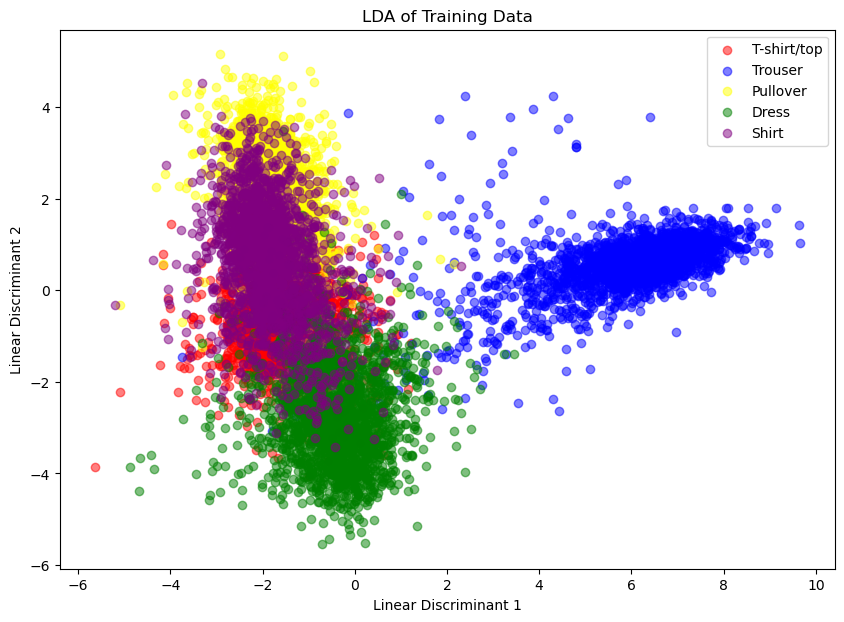

In [39]:
# Plotting the LDA results for the training data
plot_lda(train_data_lda, train_labels, 'LDA of Training Data')

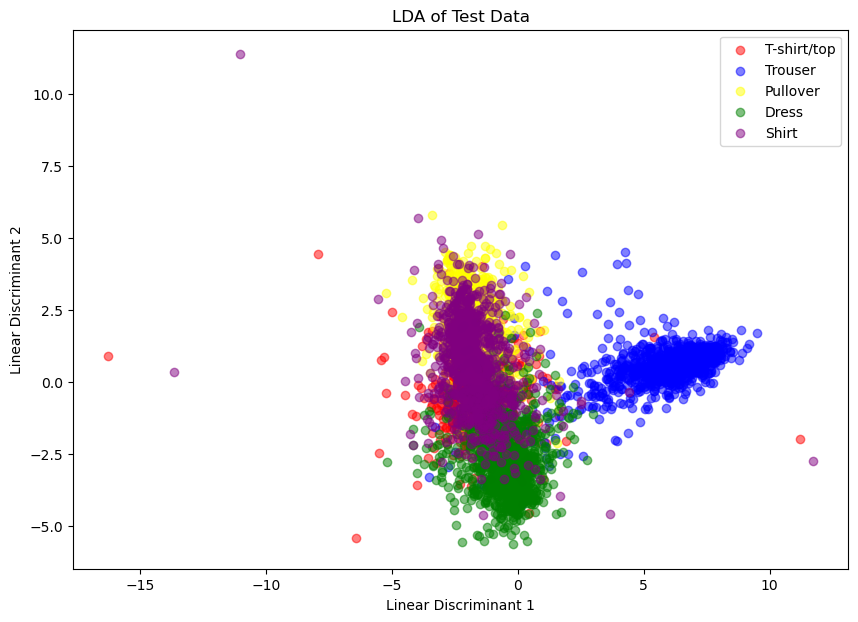

In [40]:
# Plotting the LDA results for the test data
plot_lda(test_data_lda, test_labels, 'LDA of Test Data')

In [41]:
# Calculate the explained variance ratio
explained_variance_ratio_lda = lda.explained_variance_ratio_
print(f"Explained variance by the first four linear discriminants: {explained_variance_ratio_lda}")
# Calculate the total variance explained by the first four linear discriminants
total_explained_variance_lda = np.sum(explained_variance_ratio_lda)
print(f"Total variance explained by the first four linear discriminants: {total_explained_variance_lda * 100:.2f}%")

Explained variance by the first four linear discriminants: [0.61113178 0.20240552]
Total variance explained by the first four linear discriminants: 81.35%


In [42]:
# Build the decision tree using the LDA-transformed training data
decision_tree_lda = build_tree(train_data_lda, train_labels, max_depth=5)

In [43]:
# Make predictions on the LDA-transformed test data
test_predictions_lda = predict_batch(decision_tree_lda, test_data_lda)

In [44]:
# Calculate accuracy
accuracy_lda = np.mean(test_predictions_lda == test_labels)
print(f"Accuracy with LDA: {accuracy_lda * 100:.2f}%")

# Generate the classification report with label names
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']
report_lda = classification_report(test_labels, test_predictions_lda, target_names=label_names)
print(report_lda)


Accuracy with LDA: 71.92%
              precision    recall  f1-score   support

 T-shirt/top       0.59      0.63      0.61      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.70      0.82      0.75      1000
       Dress       0.78      0.81      0.80      1000
       Shirt       0.51      0.39      0.44      1000

    accuracy                           0.72      5000
   macro avg       0.71      0.72      0.71      5000
weighted avg       0.71      0.72      0.71      5000



In [45]:
# Initialize the decision tree classifier with the same hyperparameters
clf_lda = DecisionTreeClassifier(max_depth=5)

In [46]:
# Fit the model on the LDA-transformed training data
clf_lda.fit(train_data_lda, train_labels)

DecisionTreeClassifier(max_depth=5)

In [47]:
# Make predictions on the LDA-transformed test data
test_predictions_lda = clf_lda.predict(test_data_lda)

In [48]:
# Calculate accuracy
accuracy_lda = clf_lda.score(test_data_lda, test_labels)
print(f"Accuracy with LDA: {accuracy_lda * 100:.2f}%")

Accuracy with LDA: 71.84%


In [49]:
# Generate the classification report with label names
report_lda = classification_report(test_labels, test_predictions_lda, target_names=label_names)
print(report_lda)

              precision    recall  f1-score   support

 T-shirt/top       0.59      0.63      0.61      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.70      0.82      0.75      1000
       Dress       0.78      0.81      0.79      1000
       Shirt       0.51      0.39      0.44      1000

    accuracy                           0.72      5000
   macro avg       0.71      0.72      0.71      5000
weighted avg       0.71      0.72      0.71      5000



Saving the transformed data for use in other algorithms.

In [51]:
# Save the PCA transformed data
np.save('train_data_pca.npy', train_data_pca)
np.save('test_data_pca.npy', test_data_pca)

# Save the LDA transformed data
np.save('train_data_lda.npy', train_data_lda)
np.save('test_data_lda.npy', test_data_lda)

# Save the labels
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)

print("Data saved successfully!")


Data saved successfully!
